In [1]:
print("Hello World")

Hello World


# Introduction
1. Import the _context_ module and call the set_context method of context.
2. __mode__: indicates the mode of operation, MindSpore supports two modes, GRAPH_MODE means static map mode, PYNATIVE_MODE means dynamic map mode, for handwritten digit recognition problems with static map mode can be used.
3. __device_target__: indicates the hardware information, use CPU here.


In [2]:
from mindspore import context

context.set_context(mode=context.GRAPH_MODE, device_target="CPU")

Small Note: conda install matplotlib

The type of mnist_ds: <class 'mindspore.dataset.engine.datasets_vision.MnistDataset'>
Number of pictures contained in the mnist_ds:  60000
The item of mnist_ds: dict_keys(['image', 'label'])
Tensor of image in item: (28, 28, 1)
The label of item: 5


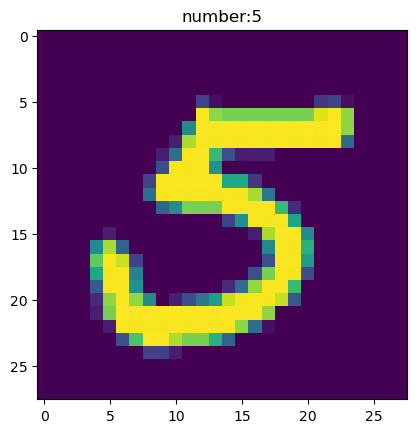

In [3]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import mindspore.dataset as ds

train_data_path = "./datasets/train"
test_data_path = "./datasets/test"
mnist_ds = ds.MnistDataset(train_data_path)
#The generated image has two columns [img, label], and the column image tensor is of type uint8.
#Tensor, range [0,255]

print('The type of mnist_ds:', type(mnist_ds))
print("Number of pictures contained in the mnist_ds: ", mnist_ds.get_dataset_size())
#int, number of batches.
#print(mnist_ds.get_batch_size())    
##Return the size of batch.

dic_ds = mnist_ds.create_dict_iterator()    
#class: dictionary
item = next(dic_ds)
#Tensor to Numpy, for matplotlib.pyplot
img = item["image"].asnumpy()   

label = item["label"].asnumpy()

print("The item of mnist_ds:", item.keys())
print("Tensor of image in item:", img.shape)
print("The label of item:", label)

#squeeze: down dimension from [28,28,1] to [28,28]
plt.imshow(np.squeeze(img))    
plt.title("number:%s"% item["label"].asnumpy())
#show: figure
plt.show()  


In [4]:
import mindspore.dataset.vision as CV
import mindspore.dataset.transforms as C
from mindspore.dataset.vision import Inter
from mindspore import dtype as mstype

def create_dataset(data_path, batch_size=32, repeat_size=1,
num_parallel_workers=1):
    
    mnist_ds = ds.MnistDataset(data_path)

    # 定义数据增强和处理所需的一些参数
    resize_height, resize_width = 32, 32
    rescale = 1.0 / 255.0
    shift = 0.0
    rescale_nml = 1 / 0.3081
    shift_nml = -1 * 0.1307 / 0.3081

    # 根据上面所定义的参数生成对应的数据增强方法，即实例化对象
    resize_op = CV.Resize((resize_height, resize_width), interpolation=Inter.LINEAR)
    rescale_nml_op = CV.Rescale(rescale_nml, shift_nml)
    rescale_op = CV.Rescale(rescale, shift)
    hwc2chw_op = CV.HWC2CHW()
    type_cast_op = C.TypeCast(mstype.int32)

    # 将数据增强处理方法映射到（使用）在对应数据集的相应部分（image，label）
    mnist_ds = mnist_ds.map(operations=type_cast_op, input_columns="label", num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(operations=resize_op, input_columns="image", num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(operations=rescale_op, input_columns="image", num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(operations=rescale_nml_op, input_columns="image", num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(operations=hwc2chw_op, input_columns="image", num_parallel_workers=num_parallel_workers)

    # 处理生成的数据集
    buffer_size = 10000
    mnist_ds = mnist_ds.shuffle(buffer_size=buffer_size)
    mnist_ds = mnist_ds.batch(batch_size, drop_remainder=True)
    mnist_ds = mnist_ds.repeat(repeat_size)

    return mnist_ds


Number of groups in the dataset: 1875
Tensor of image: (32, 1, 32, 32)
Labels: [3 9 0 5 5 2 6 5 4 6 6 4 6 8 2 6 9 5 4 2 1 9 3 1 0 2 1 1 4 5 1 8]


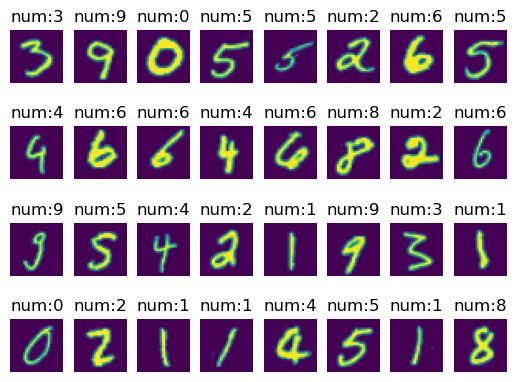

In [5]:
ms_dataset = create_dataset(train_data_path)
print('Number of groups in the dataset:', ms_dataset.get_dataset_size())

data = next(ms_dataset.create_dict_iterator(output_numpy=True))    
images = data["image"]
labels = data["label"]
print('Tensor of image:', images.shape)
print('Labels:', labels)

count = 1
for i in images:
    plt.subplot(4, 8, count)
    plt.imshow(np.squeeze(i))
    plt.title('num:%s'%labels[count-1])
    plt.xticks([])
    count += 1
    plt.axis("off")
plt.show()

In [7]:
import mindspore.nn as nn      
from mindspore.common.initializer import Normal 
class LeNet5(nn.Cell):
    def __init__(self, num_class=10, num_channel=1):
        super(LeNet5, self).__init__()	#继承父类nn.cell的__init__方法
        
        
        #nn.Conv2d的第一个参数是输入图片的通道数，即单个过滤器应有的通道数，第二个参数是输出图片的通道数
        #即过滤器的个数，第三个参数是过滤器的二维属性，它可以是一个int元组，但由于一般过滤器都是a x a形
        #式的，而且为奇数。所以这里填入单个数即可,参数pad_mode为卷积方式，valid卷积即padding为0的卷积
        #现在也比较流行same卷积，即卷积后输出的图片不会缩小。需要注意的是卷积层我们是不需要设置参数的随机
        #方式的，因为它默认会给我们选择为Noremal。
        self.conv1 = nn.Conv2d(num_channel, 6, 5, pad_mode='valid')
        self.conv2 = nn.Conv2d(6, 16, 5, pad_mode='valid')
        
        
        #nn.Dense为致密连接层，它的第一个参数为输入层的维度，第二个参数为输出的维度，第三个参数为神经网
        #络可训练参数W权重矩阵的初始化方式，默认为normal
        self.fc1 = nn.Dense(16 * 5 * 5, 120, weight_init=Normal(0.02))
        self.fc2 = nn.Dense(120, 84, weight_init=Normal(0.02))
        self.fc3 = nn.Dense(84, num_class, weight_init=Normal(0.02))
        
        #nn.ReLU()非线性激活函数，它往往比论文中的sigmoid激活函数具有更好的效益
        self.relu = nn.ReLU()
        #nn.MaxPool2d为最大池化层的定义，kernel_size为采样器的大小，stride为采样步长，本例中将其
        #都设置为2相当于将图片的宽度和高度都缩小一半
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        #nn.Flatten为输入展成平图层，即去掉那些空的维度
        self.flatten = nn.Flatten()

    def construct(self, x):
        
        #输入x，下面即是将x通过LeNet5网络执行前向传播的过程
        x = self.max_pool2d(self.relu(self.conv1(x)))
        x = self.max_pool2d(self.relu(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [8]:
print(LeNet5())

LeNet5<
  (conv1): Conv2d<input_channels=1, output_channels=6, kernel_size=(5, 5), stride=(1, 1), pad_mode=valid, padding=0, dilation=(1, 1), group=1, has_bias=False, weight_init=<mindspore.common.initializer.HeUniform object at 0x0000028DED5987F0>, bias_init=None, format=NCHW>
  (conv2): Conv2d<input_channels=6, output_channels=16, kernel_size=(5, 5), stride=(1, 1), pad_mode=valid, padding=0, dilation=(1, 1), group=1, has_bias=False, weight_init=<mindspore.common.initializer.HeUniform object at 0x0000028DED5803D0>, bias_init=None, format=NCHW>
  (fc1): Dense<input_channels=400, output_channels=120, has_bias=True>
  (fc2): Dense<input_channels=120, output_channels=84, has_bias=True>
  (fc3): Dense<input_channels=84, output_channels=10, has_bias=True>
  (relu): ReLU<>
  (max_pool2d): MaxPool2d<kernel_size=2, stride=2, pad_mode=VALID>
  (flatten): Flatten<>
  >


In [9]:
from mindspore.nn import SoftmaxCrossEntropyWithLogits

lr = 0.01	#learingrate,学习率，可以使梯度下降的幅度变小，从而可以更好的训练参数
momentum = 0.9
network = LeNet5()

#使用了流行的Momentum优化器进行优化
#vt+1=vt∗u+gradients
#pt+1=pt−(grad∗lr+vt+1∗u∗lr)
#pt+1=pt−lr∗vt+1
#其中grad、lr、p、v和u分别表示梯度、学习率、参数、力矩和动量。
net_opt = nn.Momentum(network.trainable_params(), lr, momentum)

#相当于softmax分类器
#sparse指定标签（label）是否使用稀疏模式，默认为false,reduction为损失的减少类型：mean表示平均值，一般
#情况下都是选择平均地减少
net_loss = SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')


In [10]:
from mindspore.train.callback import Callback

# custom callback function
class StepLossAccInfo(Callback):
    def __init__(self, model, eval_dataset, steps_loss, steps_eval):
        self.model = model	#计算图模型Model
        self.eval_dataset = eval_dataset	#测试数据集
        self.steps_loss = steps_loss	
        #收集step和loss值之间的关系，数据格式{"step": [], "loss_value": []}，会在后面定义
        self.steps_eval = steps_eval
        #收集step对应模型精度值accuracy的信息，数据格式为{"step": [], "acc": []}，会在后面定义

    def step_end(self, run_context):
        cb_params = run_context.original_args()
        #cur_epoch_num是CallbackParam中的定义，获得当前处于第几个epoch,一个epoch意味着训练集
        #中每一个样本都训练了一次
        cur_epoch = cb_params.cur_epoch_num
        
        #同理，cur_step_num是CallbackParam中的定义，获得当前执行到多少step
        cur_step = (cur_epoch-1)*1875 + cb_params.cur_step_num
        self.steps_loss["loss_value"].append(str(cb_params.net_outputs))
        self.steps_loss["step"].append(str(cur_step))
        if cur_step % 125 == 0:
            #调用model.eval返回测试数据集下模型的损失值和度量值，dic对象
            acc = self.model.eval(self.eval_dataset, dataset_sink_mode=False)
            self.steps_eval["step"].append(cur_step)
            self.steps_eval["acc"].append(acc["Accuracy"])


In [11]:
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor
from mindspore.nn import Accuracy
from mindspore import Model

epoch_size = 1  #每个epoch需要遍历完成图片的batch数,这里是只要遍历一次
model_path = "./models/ckpt/mindspore_quick_start/"
eval_dataset = create_dataset(test_data_path)
#调用Model高级API，将LeNet-5网络与损失函数和优化器连接到一起，具有训练和推理功能的对象。
#metrics 参数是指训练和测试期，模型要评估的一组度量，这里设置的是"Accuracy"准确度
model = Model(network, net_loss, net_opt, metrics={"Accuracy": Accuracy()} )

#保存训练好的模型参数的路径
config_ck = CheckpointConfig(save_checkpoint_steps=375, keep_checkpoint_max=16)
ckpoint_cb = ModelCheckpoint(prefix="checkpoint_lenet", directory=model_path, config=config_ck)

#回调类中提到的我们要声明的数据格式
steps_loss = {"step": [], "loss_value": []}
steps_eval = {"step": [], "acc": []}
#使用model等对象实例化StepLossAccInfo，得到具体的对象
step_loss_acc_info = StepLossAccInfo(model , eval_dataset, steps_loss, steps_eval)

#调用Model类的train方法进行训练，LossMonitor(125)每隔125个step打印训练过程中的loss值,dataset_sink_mode为设置数据下沉模式，但该模式不支持CPU，所以这里我们只能设置为False
model.train(epoch_size, ms_dataset, callbacks=[ckpoint_cb, LossMonitor(125), step_loss_acc_info], dataset_sink_mode=False)


[WARNING] ME(64844:62184,MainProcess):2023-12-15-21:14:00.369.751 [mindspore\train\model.py:1106] For StepLossAccInfo callback, {'step_end'} methods may not be supported in later version, Use methods prefixed with 'on_train' or 'on_eval' instead when using customized callbacks.


epoch: 1 step: 125, loss is 2.2808399200439453
epoch: 1 step: 250, loss is 0.5725045204162598
epoch: 1 step: 375, loss is 0.20608487725257874
epoch: 1 step: 500, loss is 0.11750323325395584
epoch: 1 step: 625, loss is 0.26220858097076416
epoch: 1 step: 750, loss is 0.008099250495433807
epoch: 1 step: 875, loss is 0.13669133186340332
epoch: 1 step: 1000, loss is 0.0542181059718132
epoch: 1 step: 1125, loss is 0.02139628864824772
epoch: 1 step: 1250, loss is 0.11164470762014389
epoch: 1 step: 1375, loss is 0.009250405244529247
epoch: 1 step: 1500, loss is 0.053011007606983185
epoch: 1 step: 1625, loss is 0.03553501144051552
epoch: 1 step: 1750, loss is 0.04955402389168739
epoch: 1 step: 1875, loss is 0.12994231283664703


Row 2, column 2 is incorrectly identified as 1, the correct value should be 9 

Row 3, column 8 is incorrectly identified as 2, the correct value should be 7 

[1 1 0 9 2 7 8 0 0 1 0 3 8 2 2 0 8 5 6 7 9 4 7 2 0 6 6 1 6 5 2 4] <--Predicted figures
[1 1 0 9 2 7 8 0 0 9 0 3 8 2 2 0 8 5 6 7 9 4 7 7 0 6 6 1 6 5 2 4] <--The right number


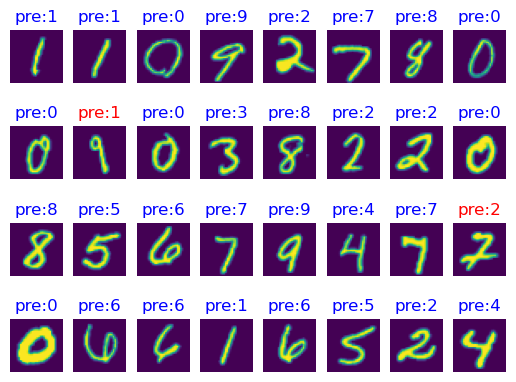

In [12]:
from mindspore import Tensor

ds_test = eval_dataset.create_dict_iterator()
data = next(ds_test)
images = data["image"].asnumpy()
labels = data["label"].asnumpy()

output = model.predict(Tensor(data['image']))   
#利用加载好的模型的predict进行预测，注意返回的是对应的（0到9）的概率
pred = np.argmax(output.asnumpy(), axis=1)
err_num = []
index = 1
for i in range(len(labels)):
    plt.subplot(4, 8, i+1)
    color = 'blue' if pred[i] == labels[i] else 'red'
    plt.title("pre:{}".format(pred[i]), color=color)
    plt.imshow(np.squeeze(images[i]))
    plt.axis("off")
    if color == 'red':
        index = 0
        print("Row {}, column {} is incorrectly identified as {}, the correct value should be {}".format(int(i/8)+1, i%8+1, pred[i], labels[i]), '\n')
if index:
    print("All the figures in this group are predicted correctly!")
print(pred, "<--Predicted figures")
print(labels, "<--The right number")
plt.show()
